**Retraining BERT to Detect Offensive Tweets**

In this script, the BERT uncased model available via Huggingface will be retrained with the OLID tweets to detect offensive Tweets. 



In [1]:
# mounting to drive to use colab
from google.colab import drive
drive.mount('/content/drive')

# load model, tokenizer
!pip install transformers
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import set_seed


model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
     "bert-base-uncased", 
     num_labels = 2, 
)


import pandas as pd 
import numpy as np
import random
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
import torch
from collections import Counter



Mounted at /content/drive
     |████████████████████████████████| 4.2 MB 8.3 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 6.6 MB 51.1 MB/s 
     |████████████████████████████████| 596 kB 65.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
# use the following when allocated memory error comes up
# CUDA out of memory error comes up during hyperparameter tuning
# below script is copied from Stackoverflow and I believe it cleans cache :)

torch.cuda.empty_cache()

In [19]:
set_seed(42)
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [20]:
# read preprocessed data
data_path = 'drive/MyDrive/NLP_Final_Assignment/data/df_preprocessed.csv'
df = pd.read_csv(data_path, sep=',', header=0)

In [21]:
df.head()
# only tweet_clean and label needed
df = df[['id', 'tweet_clean','offensive']]
df = df.set_index('id')
df.rename({'offensive': 'label', 'tweet_clean': 'text'}, axis=1, inplace=True)
df.head()

,text,label
id,,
86426,@user she should ask a few native americans wh...,1
90194,@user @user go home you are drunk! @user maga ...,1
16820,amazon is investigating chinese employees who ...,0
62688,@user someone shouldvetaken this piece of shit...,1
43605,@user @user obama wanted liberals amp; illegal...,0


In [6]:
# Preprocess data
X = list(df['text'])
y = list(df['label'])
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.1, stratify=y, shuffle=True)
X_train_tokenized = tokenizer(X_train, padding=True,  add_special_tokens=True, truncation=True)
X_val_tokenized = tokenizer(X_val, padding=True,  add_special_tokens=True, truncation=True)


In [7]:
Counter(y_train)

Counter({0: 7935, 1: 3955})

In [8]:
Counter(y_val)

Counter({0: 882, 1: 440})

In [9]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):    
    def __init__(self, encodings, labels=None):          
        self.encodings = encodings        
        self.labels = labels
     
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
      return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [10]:
# Define Trainer parameters

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

**Model Hyperparameters**

For fine-tuning a BERT Model to classify offensive Tweets, the hyperparameters used in the paper of Caselli et al. (2021) will be followed in general. Additionally, the metric to choose best model is set to f1.

The authors set maximum sequence length to 100 in their model and in their tokenizer but I skipped this so that the model is able to deal with longer sequences of text. Max sequence length then becomes 512, which the default max sequence length.


<br>


**Hyperparameter Tuning**

Following a discussion on huggingface website (https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10), I will use hyperparameter_search available to Huggingface trainer to optimize my model. 

Testing different number of training epochs, batch size and learning rate.

In [28]:
# Define Training Arguments
args = TrainingArguments(
    output_dir="drive/MyDrive/NLP_Final_Assignment/bertmodel-hs",
    evaluation_strategy='epoch',
    warmup_steps=0,
    adam_epsilon=1e-8,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [29]:
# Initialize model to be used in hyperparameter search
def model_init():
    model = BertForSequenceClassification.from_pretrained(
     "bert-base-uncased", 
     num_labels = 2, 
)
    return model

In [30]:
# define trainer with model_init

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    model_init = model_init,
)

/usr/local/lib/python3.7/dist-packages/transformers/trainer.py:333: FutureWarning: `Trainer` requires either a `model` or `model_init` argument, but not both. `model_init` will overwrite your model when calling the `train` method. This will become a fatal error in the next release.
  FutureWarning,


In [77]:
# !pip install optuna

# def my_hp_space(trial):
#     return {
#         "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
#         "num_train_epochs": trial.suggest_int("num_train_epochs", 5, 50),
#         "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
#     }
# def my_objective(metrics):
#     return metrics["eval_loss"]

# best_run = trainer.hyperparameter_search(direction="minimize", hp_space=my_hp_space, compute_objective=my_objective, n_trials=100)

# with open("/content/drive/MyDrive/NLP_Final_Assignment/bertmodel-hs/best_run.json", "w+") as f:
#   f.write(json.dumps(best_run.hyperparameters))

<br>

Hyperparameter tuning with optuna keeps facing either memory or runtime issues when done on Colab. From various trials I can conclude that lower epoch size and higher training batches seems to work better. 

Other experiments have run, changing only epoch size, here also bigger epoch size did not show better results. Keeping epoch size at 5 was the best option. Then experiments have run changing only batch size, batch size = 32 performed better than 8 or 16. 

This is in line with parameters reported by Caselli et al. (2021) when applying BERT to detect hate speech, he next experiment uses the parameters reported by then.

Below are the main parameters of the model. 

<br>

In [61]:
args = TrainingArguments(
 output_dir="drive/MyDrive/NLP_Final_Assignment/bertmodel",
    evaluation_strategy='epoch',
    per_device_train_batch_size=32,
    learning_rate=5e-5,
    warmup_steps=0,
    num_train_epochs=5,
    adam_epsilon=1e-8,
    metric_for_best_model = 'f1',
    logging_dir = 'drive/MyDrive/NLP_Final_Assignment/bertmodel/logs',
    logging_strategy='epoch',
    logging_first_step=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [62]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [63]:
bert_train_result = trainer.train() 

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 11890
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1860


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.410100,0.403184,0.829803,0.765432,0.704545,0.804329
2,0.269400,0.432526,0.819970,0.702811,0.795455,0.803381
3,0.142200,0.689482,0.807110,0.687627,0.770455,0.788826
4,0.071900,0.844968,0.815431,0.722727,0.722727,0.792203
5,0.041700,0.960599,0.820726,0.735499,0.720455,0.797114


***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
Saving model checkpoint to drive/MyDrive/NLP_Final_Assignment/bertmodel/checkpoint-500
Configuration saved in drive/MyDrive/NLP_Final_Assignment/bertmodel/checkpoint-500/config.json
Model weights saved in drive/MyDrive/NLP_Final_Assignment/bertmodel/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
Saving model checkpoint to drive/MyDrive/NLP_Final_Assignment/bertmodel/checkpoint-1000
Configuration saved in drive/MyDrive/NLP_Final_Assignment/bertmodel/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/NLP_Final_Assignment/bertmodel/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
Saving model checkpoint to drive/MyDrive/NLP_Final_Assignment/bertmodel/checkpoint-1500
Configuration saved in drive/MyDrive/NLP_Final_Assignment/bertm

Model scores are better than the first set of trials, creating the loss curves:

In [64]:
history = trainer.state.log_history

In [65]:
history
epochs = list(set([d['epoch'] for d in history if 'epoch' in d and d['epoch'] > 0]))
train_loss = [d['loss'] for d in history if 'loss' in d]
eval_loss = [d['eval_loss'] for d in history if 'eval_loss' in d]


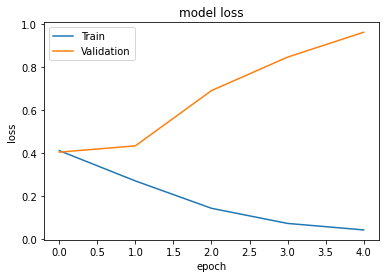

In [66]:
# Training and evaluation loss curves

plt.plot(train_loss[1:6])
plt.plot(eval_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


The validation loss is increasing while the training loss decreases. This would be problematic because model is overfitting to the train set and cannot generalize to the validation dataset, or other test sets. Secondly, as the model sees more training data, the scores of the model does not increase but they decrease. This indicates that model does not learn further from the training data. 

Lowering learning rate to see if slower training would solve the increasing validation error problem: 



In [14]:
args = TrainingArguments(
 output_dir="drive/MyDrive/NLP_Final_Assignment/bertmodel_lr_lower",
    evaluation_strategy='epoch',
    per_device_train_batch_size=32,
    learning_rate=1e-6,
    warmup_steps=0,
    num_train_epochs=5,
    adam_epsilon=1e-8,
    metric_for_best_model = 'f1',
    logging_dir = 'drive/MyDrive/NLP_Final_Assignment/bertmodel_lr_lower/logs',
    logging_strategy='epoch',
    logging_first_step=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [15]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [16]:
bert_train_result2 = trainer.train() 

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 11890
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1860


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.360600,0.470687,0.805598,0.753463,0.618182,0.769852
2,0.346900,0.458524,0.804841,0.727500,0.661364,0.774921
3,0.371600,0.452137,0.804085,0.726817,0.659091,0.773904
4,0.367200,0.454877,0.804085,0.727960,0.656818,0.773615
5,0.365900,0.456445,0.803328,0.728426,0.652273,0.772301


***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
Saving model checkpoint to drive/MyDrive/NLP_Final_Assignment/bertmodel_lr_lower/checkpoint-500
Configuration saved in drive/MyDrive/NLP_Final_Assignment/bertmodel_lr_lower/checkpoint-500/config.json
Model weights saved in drive/MyDrive/NLP_Final_Assignment/bertmodel_lr_lower/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
Saving model checkpoint to drive/MyDrive/NLP_Final_Assignment/bertmodel_lr_lower/checkpoint-1000
Configuration saved in drive/MyDrive/NLP_Final_Assignment/bertmodel_lr_lower/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/NLP_Final_Assignment/bertmodel_lr_lower/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
Saving model checkpoint to drive/MyDrive/NLP_Final_Assignment/bertmodel_lr_lower/checkpoint-1500


In [17]:
history = trainer.state.log_history
epochs = list(set([d['epoch'] for d in history if 'epoch' in d and d['epoch'] > 0]))
train_loss = [d['loss'] for d in history if 'loss' in d]
eval_loss = [d['eval_loss'] for d in history if 'eval_loss' in d]

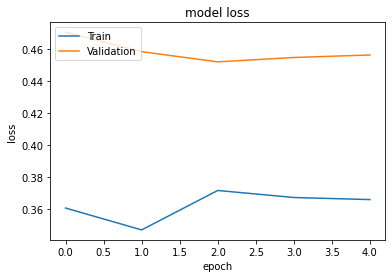

In [18]:
# Training and evaluation loss curves

plt.plot(train_loss[1:6])
plt.plot(eval_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Now the training error is decreasing and increasing after the first epoch. It seems that the model is not learning further as it sees more training data but the validation loss is not increasing constantly either. Both the loss and scores of the model stay stable across epochs.

Transformers allow retraining the model with the available data. I will try this out to see whether this increases the performance of the model. Setting do_train argument to True to pre-train the BERT model with OLID dataset.

In [20]:
args = TrainingArguments(
 output_dir="drive/MyDrive/NLP_Final_Assignment/bertmodel-pretrained",
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    do_train = True,
    learning_rate=1e-6,
    warmup_steps=0,
    num_train_epochs=5,
    adam_epsilon=1e-8,
    metric_for_best_model = 'f1',
    logging_dir = 'drive/MyDrive/NLP_Final_Assignment/bertmodel-pretrained/logs',
    logging_strategy='epoch',
    logging_first_step=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [21]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [22]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 11890
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1860


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.476300,0.475710,0.785174,0.745283,0.538636,0.737373
2,0.444300,0.463250,0.792738,0.711735,0.634091,0.759729
3,0.434900,0.461104,0.795008,0.718346,0.631818,0.761581
4,0.430700,0.460554,0.797277,0.731183,0.618182,0.761831
5,0.428500,0.460938,0.800303,0.739130,0.618182,0.764738


***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
Saving model checkpoint to drive/MyDrive/NLP_Final_Assignment/bertmodel-pretrained/checkpoint-500
Configuration saved in drive/MyDrive/NLP_Final_Assignment/bertmodel-pretrained/checkpoint-500/config.json
Model weights saved in drive/MyDrive/NLP_Final_Assignment/bertmodel-pretrained/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
Saving model checkpoint to drive/MyDrive/NLP_Final_Assignment/bertmodel-pretrained/checkpoint-1000
Configuration saved in drive/MyDrive/NLP_Final_Assignment/bertmodel-pretrained/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/NLP_Final_Assignment/bertmodel-pretrained/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
Saving model checkpoint to drive/MyDrive/NLP_Final_Assignment/bertmodel-pretrained/ch

TrainOutput(global_step=1860, training_loss=0.4429270788706759, metrics={'train_runtime': 2865.6407, 'train_samples_per_second': 20.746, 'train_steps_per_second': 0.649, 'total_flos': 8584743319851000.0, 'train_loss': 0.4429270788706759, 'epoch': 5.0})

In [23]:
history = trainer.state.log_history

epochs = list(set([d['epoch'] for d in history if 'epoch' in d and d['epoch'] > 0]))
train_loss = [d['loss'] for d in history if 'loss' in d]
eval_loss = [d['eval_loss'] for d in history if 'eval_loss' in d]

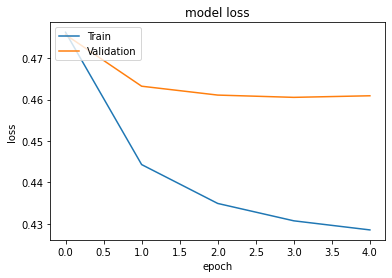

In [24]:
# Training and evaluation loss curves

plt.plot(train_loss[1:6])
plt.plot(eval_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Training and validation scores decrease as model learns from the training dataset but the validation stops decreasing as training loss continues to decrease. 

The difference between the first trial and this one regarding loss metrics can be expected as in the first trial the model does not begin from scratch. Here, the weights are initialized randomly. When do_train is false, the model did not learn further from the available data, and now it does. However, resulting model macros are lower compared to the first model, which could be an indication that the pre-trained BERT Model was already good for the task. 

The f1 score as well as other metrics are increasing per epoch, I will test with more epochs to see if I am stopping the learning too early and if the model will learn further to reach the same scores as the pre-trained BERT model. 

In [35]:
args = TrainingArguments(
 output_dir="drive/MyDrive/NLP_Final_Assignment/bertmodel-pretrained15",
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    do_train = True,   
    do_eval=True,
    learning_rate=1e-6,
    warmup_steps=0,
    num_train_epochs=15,
    adam_epsilon=1e-8,
    metric_for_best_model = 'f1',
    logging_dir = 'drive/MyDrive/NLP_Final_Assignment/bertmodel-pretrained15/logs',
    logging_strategy='epoch',
    logging_first_step=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [36]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [37]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 11890
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5580


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.630200,0.608007,0.667171,0.000000,0.000000,0.400181
2,0.582500,0.548661,0.723903,0.719298,0.279545,0.611541
3,0.524400,0.497150,0.764750,0.667532,0.584091,0.726029
4,0.478900,0.478442,0.774584,0.668246,0.640909,0.743532
5,0.455300,0.464923,0.789713,0.701493,0.640909,0.757780
6,0.441600,0.461274,0.789713,0.702500,0.638636,0.757473
7,0.429300,0.459976,0.792738,0.698565,0.663636,0.763619
8,0.421800,0.459233,0.793495,0.709273,0.643182,0.761683
9,0.413400,0.459302,0.794251,0.701923,0.663636,0.765059
10,0.411600,0.458639,0.790469,0.693587,0.663636,0.761462


***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to drive/MyDrive/NLP_Final_Assignment/bertmodel-pretrained15/checkpoint-500
Configuration saved in drive/MyDrive/NLP_Final_Assignment/bertmodel-pretrained15/checkpoint-500/config.json
Model weights saved in drive/MyDrive/NLP_Final_Assignment/bertmodel-pretrained15/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
Saving model checkpoint to drive/MyDrive/NLP_Final_Assignment/bertmodel-pretrained15/checkpoint-1000
Configuration saved in drive/MyDrive/NLP_Final_Assignment/bertmodel-pretrained15/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/N

TrainOutput(global_step=5580, training_loss=0.45341125419062955, metrics={'train_runtime': 8614.5139, 'train_samples_per_second': 20.703, 'train_steps_per_second': 0.648, 'total_flos': 2.5754229959553e+16, 'train_loss': 0.45341125419062955, 'epoch': 15.0})

The overall results got a little bit better than training with 5 epochs but after 8-9 epochs validation loss stops decreasing.

Three out of four datasets do not have long texts. Only the Wikipedia data have longer sequences, and even then in the 95 percentile distribution of the sequence length, it is at 308. We know from previous studies and the OffensEval results that setting limit to maximum length of sequence increases model performance. Here I will set it to 256, which is the half of the maximum sequence length BERT is able to handle without excluding text from more than 5% of the wikipedia set.


In [22]:
# Preprocess data, again this time max_seq
X = list(df['text'])
y = list(df['label'])
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.1, stratify=y, shuffle=True)
X_train_tokenized = tokenizer(X_train, max_length=256,
                              truncation=True,
                              add_special_tokens=True,
                              padding='max_length')
X_val_tokenized = tokenizer(X_val, 
                            max_length=256, 
                            truncation=True,
                            add_special_tokens=True,
                            padding='max_length')

In [23]:
# Create torch dataset with new tokens
class Dataset(torch.utils.data.Dataset):    
    def __init__(self, encodings, labels=None):          
        self.encodings = encodings        
        self.labels = labels
     
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
      return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [24]:
args = TrainingArguments(
 output_dir="drive/MyDrive/NLP_Final_Assignment/bertmodel_maxlen2",
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    learning_rate=1e-6,
    do_train=True,
    do_eval=True,
    warmup_steps=0,
    num_train_epochs=15,
    adam_epsilon=1e-8,
    metric_for_best_model = 'f1',
    logging_dir = 'drive/MyDrive/NLP_Final_Assignment/bertmodel_maxlen2/logs',
    logging_strategy='epoch',
    logging_first_step=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [25]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [26]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 11890
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5580


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.424700,0.431071,0.812405,0.769663,0.622727,0.777122
2,0.414600,0.422620,0.812405,0.730769,0.690909,0.785789
3,0.401600,0.423219,0.812405,0.728571,0.695455,0.786307
4,0.394700,0.424374,0.818457,0.742718,0.695455,0.792191
5,0.387500,0.424020,0.820726,0.753117,0.686364,0.793373
6,0.382100,0.424921,0.822239,0.759494,0.681818,0.794328
7,0.375900,0.426619,0.821483,0.748780,0.697727,0.795402
8,0.372400,0.429368,0.822239,0.760814,0.679545,0.794062
9,0.365200,0.429546,0.825265,0.759305,0.695455,0.798858
10,0.359900,0.430605,0.819970,0.737089,0.713636,0.795657


***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
Saving model checkpoint to drive/MyDrive/NLP_Final_Assignment/bertmodel_maxlen2/checkpoint-500
Configuration saved in drive/MyDrive/NLP_Final_Assignment/bertmodel_maxlen2/checkpoint-500/config.json
Model weights saved in drive/MyDrive/NLP_Final_Assignment/bertmodel_maxlen2/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
Saving model checkpoint to drive/MyDrive/NLP_Final_Assignment/bertmodel_maxlen2/checkpoint-1000
Configuration saved in drive/MyDrive/NLP_Final_Assignment/bertmodel_maxlen2/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/NLP_Final_Assignment/bertmodel_maxlen2/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1322
  Batch size = 8
Saving model checkpoint to drive/MyDrive/NLP_Final_Assignment/bertmodel_maxlen2/checkpoint-1500
Configu

TrainOutput(global_step=5580, training_loss=0.37637570006873017, metrics={'train_runtime': 7603.924, 'train_samples_per_second': 23.455, 'train_steps_per_second': 0.734, 'total_flos': 2.3462928361728e+16, 'train_loss': 0.37637570006873017, 'epoch': 15.0})

In [27]:
history = trainer.state.log_history

epochs = list(set([d['epoch'] for d in history if 'epoch' in d and d['epoch'] > 0]))
train_loss = [d['loss'] for d in history if 'loss' in d]
eval_loss = [d['eval_loss'] for d in history if 'eval_loss' in d]

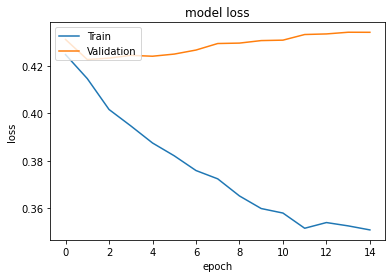

In [28]:
# Training and evaluation loss curves

plt.plot(train_loss[1:16])
plt.plot(eval_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Model scores are higher than the previous model. Only one model produced better f1 scores but ever increasing validation error in that model indicates that the model cannot perform well with unseen data. Therefore, this final model will be selected for predictions. 